In [147]:
from gridworld import *
from tqdm import trange
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#S-Learning

# gw = gridworld((5, 5), (0, 4), (4, 4), [(o, 4) for o in range(1, 4)], 0.9, 0, 100, 0)
# y = .95
gw = gridworld((4, 4), (0, 3), (3, 3), [(o, 3) for o in range(1, 3)], 0.9, 0, 100, 0)
y = .95

In [155]:
# Set learning parameters
lr = .7
num_episodes = 10000

In [156]:
def dist_error_state(state, error_state):
    return ( np.sqrt( (state[0] - error_state[0])**2 + (state[1] - error_state[1])**2 ) )

In [157]:
risk_states = np.zeros((gw.M, gw.N))
for i in range(gw.M):
    for j in range(gw.N):
#         if (i, j) in gw.error_states:
#             risk_states[i,j] == 0.
#         if (i, j) == gw.goal:
#             risk_states[i,j] == 0.
#         else:
        sm = 100.
        for e in gw.error_states:
            #sm += np.exp( - dist_error_state([i,j], e) )
            sm = min(sm, dist_error_state([i,j], e))
        risk_states[i,j] = sm

In [158]:
risk_states
np.random.seed(1)

np.min(risk_states)
np.max(risk_states)
risk_states = (risk_states - np.min(risk_states))/(np.max(risk_states) - np.min(risk_states)) * 5
risk_states

array([[3.16227766, 2.23606798, 1.41421356, 1.        ],
       [3.        , 2.        , 1.        , 0.        ],
       [3.        , 2.        , 1.        , 0.        ],
       [3.16227766, 2.23606798, 1.41421356, 1.        ]])

0.0

3.1622776601683795

array([[5.        , 3.53553391, 2.23606798, 1.58113883],
       [4.74341649, 3.16227766, 1.58113883, 0.        ],
       [4.74341649, 3.16227766, 1.58113883, 0.        ],
       [5.        , 3.53553391, 2.23606798, 1.58113883]])

In [159]:
#Empirically estimate safety
num_sims = 10000
def estimate_rr(pi):
    rewards = []
    discounted = []
    risks = []
    discounted_reward = 0
    for i in range(num_sims):
        s = gw.reset()
        reward = 0
        d = False
        j = 0
        risk_dist = 0
        while(j < 1000):
            a = pi[s[0],s[1]]
            s1,r,d = gw.step(a)
            reward += r
            risk_dist += risk_states[s[0], s[1]]                     
            if d == True:
                if s1 in gw.error_states:
                    discounted_reward = 0
                else:
                    discounted_reward = pow(y, j) * r
                break
            s = s1
            j += 1
        rewards.append(reward)
        discounted.append(discounted_reward)
        risks.append(risk_dist)
    return sum(discounted)/float(num_sims), sum(rewards)/float(num_sims), sum(risks)/float(num_sims)  

In [166]:
trials = 3
Q_list = []
reward_trial_list = []
risk_probab_list = []
trajecs = []
factor = 0.16
'''
0.18, 0.2 - little risk
0.25 - trade-off
0.3, 0.35 - too risky
'''
for k in range(trials):
    Q = np.zeros((gw.M, gw.N, 4))
    Q_ = np.zeros((gw.M, gw.N, 4))
    mainQ = np.zeros((gw.M, gw.N, 4))
    jList = []
    rList = []
    risky = 0
    for i in range(num_episodes):
        if i%10000 == 1:
            print('Episode', i)
        #Reset environment and get first new observation
        s = gw.reset()
        rAll = 0
        d = False
        j = 0
        temp_tr = []
        #The Q-Table learning algorithm
        while j < 100:
            j+=1
            #Choose an action by greedily (with noise) picking from Q table
            a = np.argmax(Q[s[0],s[1],:] + np.random.randn(1,4)*(1./(i+1)))
            #Get new state and reward from environment
            s1,r,d = gw.step(a)
            temp_tr.append(s1)

#             r_ = 0
#             if s1 in gw.error_states:
#                 r_ = 1
#                 risky += 1

            #Update Q-Table with new knowledge
            risky += risk_states[s[0], s[1]]
            Q[s[0], s[1],a] = Q[s[0], s[1],a] + lr*(r + y*np.max(Q[s1[0], s1[1],:]) - Q[s[0], s[1],a])
            Q_[s[0], s[1],a] = Q_[s[0], s[1],a] + lr*(risk_states[s[0], s[1]] + y*np.max(Q_[s1[0], s1[1],:]) - Q_[s[0], s[1],a])
            mainQ = factor * Q + Q_
            #print np.mean(mainQ, axis = 2)
            #print()
            rAll += r
            s = s1
            if d == True:
                break
        jList.append(j)
        rList.append(rAll)
        trajecs.append(temp_tr)
    Q_list.append(mainQ)

#     v = np.mean(mainQ, axis = 2)
#     gw.print_v(v)

    pi = np.argmax(mainQ, axis = 2)
    gw.print_policy(pi)
    E_dis_reward, E_reward, E_risk = estimate_rr(pi)
    print "Mean reward (empirical)", E_dis_reward
    print "Successful Episodes ", E_reward
    print "Safety ", E_risk
    reward_trial_list.append(sum(rList)/float(num_episodes))
    print "Score over time: " +  str(sum(rList)/float(num_episodes))
    risk_probab_list.append(risky/float(num_episodes))
#     print "Risk probab: " +  str(risky/float(num_episodes))
    
#     window = int(num_episodes/10)

#     plt.figure(figsize=[9,16])
#     plt.subplot(411)
#     plt.plot(pd.Series(jList).rolling(window).mean())
#     plt.title('Step Moving Average ({}-episode window)'.format(window))
#     plt.ylabel('Moves')
#     plt.xlabel('Episode')

#     plt.subplot(412)
#     plt.plot(pd.Series(rList).rolling(window).mean())
#     plt.title('Reward Moving Average ({}-episode window)'.format(window))
#     plt.ylabel('Reward')
#     plt.xlabel('Episode')

#     plt.tight_layout(pad=2)
#     plt.show()meanQ = np.mean(np.array(Q_list), axis = 0)


gw.print_gw()
meanQ = np.mean(np.array(Q_list), axis = 0)
maxv = np.mean(meanQ, axis = 2)
gw.print_v(maxv)
meanpi = np.argmax(meanQ, axis = 2)
gw.print_policy(meanpi)
E_dis_reward, E_reward, E_risk = estimate_rr(meanpi)
print "Mean reward (empirical)", E_dis_reward
print "Successful Episodes ", E_reward
print "Safety ", E_risk

'\n0.18, 0.2 - little risk\n0.25 - trade-off\n0.3, 0.35 - too risky\n'

('Episode', 1)


,0,1,2,3
0,⬇,⬅,⬅,⬅
1,⬇,⬅,⬇,E
2,➡,➡,⬇,E
3,⬆,⬆,➡,G


Mean reward (empirical) 57.2007726773
Successful Episodes  92.08
Safety  31.97490564602524
Score over time: 91.57
('Episode', 1)


,0,1,2,3
0,⬆,➡,⬇,⬅
1,➡,➡,⬅,E
2,➡,➡,⬇,E
3,➡,⬆,⬇,G


Mean reward (empirical) 8.07166596181
Successful Episodes  53.07
Safety  102.72774198276305
Score over time: 89.1
('Episode', 1)


,0,1,2,3
0,⬇,➡,⬇,⬅
1,➡,➡,⬇,E
2,➡,⬆,⬇,E
3,➡,➡,➡,G


Mean reward (empirical) 70.1355976095
Successful Episodes  89.56
Safety  10.497443249185972
Score over time: 88.51


,0,1,2,3
0,-,-,-,S
1,-,-,-,E
2,-,-,-,E
3,-,-,-,G


,0,1,2,3
0,42.07,39.52,38.49,33
1,34.72,32.96,22.85,E
2,33.77,27.48,17.00,E
3,36.81,25.32,16.65,G


,0,1,2,3
0,⬇,➡,⬅,⬅
1,➡,➡,⬇,E
2,➡,⬆,⬇,E
3,➡,⬆,➡,G


Mean reward (empirical) 31.2868399171
Successful Episodes  88.0
Safety  75.5380481845976


,0,1,2,3
0,⬇,⬇,⬅,⬅
1,⬇,⬇,⬅,E
2,➡,⬇,⬆,E
3,➡,➡,➡,G


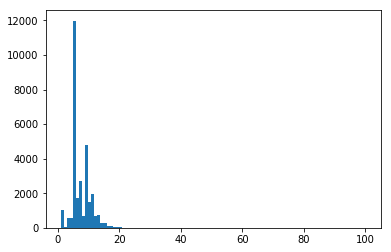

In [173]:
_ = plt.hist([len(o) for o in trajecs], bins=100)